In [6]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#print('done')

In [2]:
#Load income dataset

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
row_names = ["Age", "Workclass", "Fnlwgt", "Education", "EducationNum", "MaritalStatus",
        "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss",
        "HoursPerWeek", "Country", "Income"]
us_adult_income = pd.read_csv(dataset, names=row_names,na_values=[' ?'])

In [3]:
#Basic preprocessing and one hot encoding

del us_adult_income['CapitalGain']
del us_adult_income['CapitalLoss']
del us_adult_income['Education']
del us_adult_income['Relationship']
del us_adult_income['Country']
del us_adult_income['Fnlwgt']

#print(us_adult_income)

one_hot_encoding = pd.get_dummies(us_adult_income)
one_hot_encoding.fillna(one_hot_encoding.mean(),inplace=True)
one_hot_encoding["Income"] = one_hot_encoding['Income_ >50K']
del one_hot_encoding['Income_ <=50K']
del one_hot_encoding['Income_ >50K']

X = one_hot_encoding.iloc[:,0:-1]
Y = one_hot_encoding.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [4]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6214
           1       0.79      0.34      0.48      1927

    accuracy                           0.82      8141
   macro avg       0.81      0.66      0.68      8141
weighted avg       0.82      0.82      0.79      8141



Text(0, 0.5, 'Cross-validated accuracy')

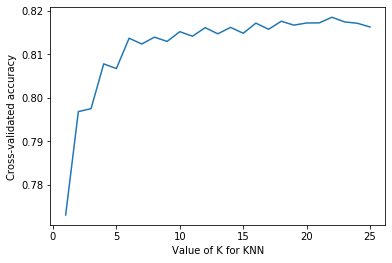

In [5]:
#Start KNN implementation. Do elbow method to define number of K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [8]:
# Train the KNN model and use k=18 based on above graph
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6214
           1       0.66      0.50      0.57      1927

    accuracy                           0.82      8141
   macro avg       0.76      0.71      0.73      8141
weighted avg       0.81      0.82      0.81      8141



In [9]:
#Train the GNB model

gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.95      0.38      0.55      6214
           1       0.32      0.93      0.47      1927

    accuracy                           0.51      8141
   macro avg       0.63      0.66      0.51      8141
weighted avg       0.80      0.51      0.53      8141



In [10]:
#Train the XGB model

xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6214
           1       0.69      0.59      0.63      1927

    accuracy                           0.84      8141
   macro avg       0.78      0.75      0.76      8141
weighted avg       0.83      0.84      0.83      8141



In [11]:
#Prepare Y_test for Manifold
Y_testMf = Y_test.to_frame()
Y_testMf = Y_testMf.replace(0, 'False')
Y_testMf = Y_testMf.replace(1, 'True')
Y_testMf = Y_testMf.values.tolist()

Y_testMfFlat = []
for sublist in Y_testMf:
    for item in sublist:
        Y_testMfFlat.append(item)

In [12]:
#Prepare RF dataset for Manifold
yPredRFpp = rf.predict_proba(X_test)

yPredRFpp0 = yPredRFpp[:,0]
yPredRFpp1 = yPredRFpp[:,1]

yPredRFpp0 = yPredRFpp0.tolist()
yPredRFpp1 = yPredRFpp1.tolist()

yPredRFppFinal = [{'True': f, 'False': c} for f, c in zip(yPredRFpp1, yPredRFpp0)]


#Prepare GNB dataset for Manifold
yPredGNBpp = gnb.predict_proba(X_test)

yPredGNBpp0 = yPredGNBpp[:,0]
yPredGNBpp1 = yPredGNBpp[:,1]

yPredGNBpp0 = yPredGNBpp0.tolist()
yPredGNBpp1 = yPredGNBpp1.tolist()

yPredGNBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredGNBpp1, yPredGNBpp0)]


#Prepare KNN dataset for Manifold
yPredKNNpp = knn.predict_proba(X_test)

yPredKNNpp0 = yPredKNNpp[:,0]
yPredKNNpp1 = yPredKNNpp[:,1]

yPredKNNpp0 = yPredKNNpp0.tolist()
yPredKNNpp1 = yPredKNNpp1.tolist()

yPredKNNppFinal = [{'True': f, 'False': c} for f, c in zip(yPredKNNpp1, yPredKNNpp0)]


#Prepare XGB dataset for Manifold
yPredXGBpp = xgbModel.predict_proba(X_test)
yPredXGBpp = yPredXGBpp.astype(np.float64)

yPredXGBpp0 = yPredXGBpp[:,0]
yPredXGBpp1 = yPredXGBpp[:,1]

yPredXGBpp0 = yPredXGBpp0.tolist()
yPredXGBpp0 = yPredXGBpp1.tolist()

yPredXGBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredXGBpp1, yPredXGBpp0)]

In [13]:
#Insert all data into one list for passing to Manifold later

allModels = []
allModels.append(yPredGNBppFinal)
allModels.append(yPredRFppFinal)
allModels.append(yPredKNNppFinal)
allModels.append(yPredXGBppFinal)

In [14]:
#Call Manifold to get visualization
#Click export segmentation after running this cell to export the indices in desired segments

from mlvis import Manifold
Manifold(props={'data': {
    'x': X_test,
    'yPred': allModels,
    'yTrue': Y_testMfFlat
}})

Manifold(props='{"data": {"x": [{"Age": 27, "EducationNum": 10, "HoursPerWeek": 38, "Workclass_ Federal-gov": …

In [15]:
#Index for segments from Manifold is exported here
segments = [[4,8,10,20,25,27,32,36,37,52,53,54,61,69,71,74,77,81,84,85,88,90,97,98,103,108,111,113,117,119,131,133,137,161,164,177,180,182,190,196,199,200,201,202,204,207,208,219,220,222,225,227,232,234,237,248,250,251,252,253,261,271,273,275,277,284,285,286,288,298,303,310,315,324,325,326,345,351,354,358,362,368,369,371,375,385,391,394,400,405,416,420,422,425,430,431,433,436,447,451,467,468,469,472,475,479,480,484,487,488,489,494,495,496,497,502,504,513,519,535,537,542,543,544,548,563,573,575,584,596,600,607,609,614,629,631,632,634,643,646,651,655,656,660,669,684,686,697,698,706,730,739,740,746,749,771,774,776,778,781,785,792,793,794,797,799,806,821,823,827,831,835,844,845,854,860,861,862,865,869,870,874,877,881,884,888,902,905,908,915,923,924,930,931,934,940,948,950,955,956,957,959,970,980,987,990,992,995,999,1004,1011,1013,1015,1020,1021,1022,1029,1034,1038,1041,1042,1043,1044,1046,1055,1056,1059,1062,1066,1067,1068,1070,1072,1074,1075,1076,1078,1085,1087,1088,1090,1091,1093,1101,1104,1105,1110,1123,1124,1126,1128,1137,1139,1145,1147,1159,1160,1163,1164,1166,1168,1169,1175,1177,1179,1187,1189,1196,1197,1198,1202,1209,1214,1217,1220,1225,1250,1251,1255,1259,1260,1267,1273,1279,1281,1282,1284,1287,1289,1294,1296,1317,1329,1336,1344,1362,1368,1391,1404,1407,1408,1413,1418,1424,1427,1430,1434,1437,1445,1446,1449,1452,1453,1455,1457,1458,1462,1464,1470,1472,1473,1486,1491,1492,1495,1503,1504,1506,1516,1517,1518,1522,1527,1529,1532,1533,1538,1543,1557,1559,1561,1567,1568,1574,1590,1599,1612,1621,1626,1630,1639,1643,1645,1646,1650,1654,1655,1667,1672,1675,1678,1685,1691,1696,1701,1712,1718,1720,1723,1731,1746,1756,1757,1761,1767,1770,1773,1775,1780,1782,1785,1786,1787,1789,1790,1799,1802,1809,1815,1818,1819,1823,1826,1828,1829,1837,1839,1844,1846,1848,1849,1857,1863,1877,1888,1893,1902,1911,1914,1928,1931,1942,1957,1960,1970,1973,1979,1993,1994,1997,1999,2006,2009,2011,2014,2018,2019,2023,2031,2033,2036,2040,2046,2055,2063,2065,2078,2079,2082,2084,2085,2091,2094,2099,2108,2109,2111,2114,2117,2119,2121,2124,2138,2142,2151,2156,2159,2160,2162,2167,2170,2176,2177,2180,2181,2192,2197,2221,2223,2226,2235,2236,2237,2239,2244,2250,2251,2253,2259,2260,2265,2270,2290,2309,2311,2312,2315,2317,2318,2321,2328,2332,2334,2340,2343,2348,2352,2354,2356,2361,2373,2379,2380,2383,2386,2387,2395,2396,2402,2403,2421,2423,2426,2428,2431,2436,2444,2453,2456,2459,2461,2464,2477,2485,2494,2495,2504,2509,2513,2520,2521,2523,2525,2531,2536,2537,2538,2548,2556,2560,2566,2571,2580,2584,2596,2607,2610,2619,2620,2621,2622,2623,2625,2641,2643,2662,2669,2671,2674,2685,2687,2690,2696,2700,2701,2708,2709,2715,2717,2719,2720,2721,2725,2729,2731,2733,2740,2741,2742,2743,2746,2747,2750,2752,2757,2762,2764,2770,2771,2776,2778,2780,2784,2786,2794,2795,2798,2805,2813,2818,2820,2822,2832,2836,2838,2845,2846,2862,2871,2873,2875,2893,2896,2900,2903,2915,2932,2935,2942,2945,2955,2959,2962,2971,2973,2976,2977,2993,2995,3004,3007,3011,3012,3019,3020,3025,3038,3046,3048,3049,3060,3062,3063,3064,3068,3073,3078,3079,3081,3082,3085,3094,3095,3096,3099,3105,3107,3113,3114,3116,3119,3120,3123,3125,3136,3138,3142,3144,3153,3157,3158,3159,3172,3178,3181,3184,3186,3191,3194,3195,3199,3208,3216,3217,3225,3226,3228,3229,3234,3243,3245,3247,3261,3265,3267,3272,3280,3286,3290,3296,3299,3301,3304,3306,3312,3314,3316,3324,3325,3326,3328,3339,3342,3345,3346,3350,3355,3356,3359,3368,3378,3382,3387,3399,3402,3407,3416,3424,3425,3427,3428,3430,3432,3438,3449,3459,3462,3464,3473,3474,3476,3477,3478,3480,3481,3485,3487,3496,3499,3500,3503,3507,3508,3513,3527,3528,3529,3535,3541,3549,3559,3561,3574,3579,3581,3584,3586,3592,3595,3601,3608,3611,3613,3617,3639,3644,3647,3650,3658,3661,3678,3684,3688,3690,3691,3700,3709,3710,3712,3713,3714,3723,3727,3729,3732,3743,3747,3748,3755,3768,3775,3776,3784,3787,3799,3801,3802,3807,3812,3814,3818,3823,3824,3826,3828,3837,3842,3851,3853,3860,3865,3868,3873,3874,3877,3883,3886,3887,3889,3894,3897,3899,3907,3908,3910,3926,3930,3931,3935,3937,3948,3950,3953,3954,3955,3957,3961,3962,3973,3976,3982,3983,3984,3989,3991,3993,3995,3999,4014,4015,4022,4023,4026,4028,4029,4035,4040,4050,4053,4063,4072,4080,4081,4090,4092,4093,4096,4110,4111,4114,4117,4120,4127,4130,4139,4142,4144,4146,4148,4155,4160,4161,4166,4167,4168,4186,4188,4193,4195,4198,4199,4201,4204,4205,4210,4211,4213,4214,4216,4221,4231,4233,4236,4238,4241,4257,4266,4274,4277,4281,4285,4292,4295,4296,4302,4305,4310,4313,4315,4317,4318,4322,4324,4329,4338,4339,4344,4350,4358,4360,4364,4370,4376,4380,4382,4386,4394,4395,4409,4415,4416,4417,4420,4421,4443,4452,4462,4464,4467,4474,4493,4494,4496,4501,4505,4510,4511,4515,4521,4522,4526,4529,4546,4554,4555,4557,4561,4562,4564,4566,4571,4582,4583,4584,4588,4594,4596,4597,4598,4600,4604,4605,4608,4615,4616,4624,4632,4634,4641,4644,4649,4652,4660,4661,4664,4665,4667,4672,4675,4680,4685,4707,4711,4716,4721,4726,4730,4733,4743,4751,4757,4760,4764,4773,4782,4785,4790,4791,4802,4807,4809,4811,4816,4818,4822,4825,4832,4835,4836,4839,4841,4844,4850,4852,4854,4865,4872,4875,4877,4881,4890,4891,4892,4898,4900,4904,4909,4914,4919,4920,4932,4934,4936,4937,4940,4942,4945,4948,4955,4960,4963,4997,5011,5021,5022,5027,5033,5035,5040,5043,5046,5064,5065,5066,5076,5077,5084,5086,5087,5090,5100,5107,5109,5114,5117,5119,5126,5129,5130,5133,5145,5157,5158,5164,5167,5171,5178,5180,5181,5185,5189,5201,5203,5205,5209,5213,5221,5223,5225,5235,5248,5249,5254,5255,5260,5263,5266,5268,5270,5272,5273,5276,5278,5281,5282,5287,5288,5290,5295,5296,5321,5324,5327,5330,5346,5348,5356,5363,5374,5381,5383,5385,5390,5391,5392,5400,5401,5406,5407,5414,5419,5424,5427,5431,5438,5439,5441,5443,5444,5453,5456,5469,5471,5475,5486,5488,5496,5497,5498,5504,5515,5528,5530,5542,5545,5552,5553,5555,5558,5562,5567,5571,5572,5581,5584,5585,5596,5597,5604,5606,5607,5616,5622,5628,5635,5639,5645,5655,5657,5659,5662,5665,5668,5671,5678,5679,5681,5685,5689,5690,5691,5695,5696,5715,5719,5727,5730,5731,5734,5735,5736,5740,5744,5746,5747,5748,5753,5754,5758,5761,5772,5775,5782,5797,5807,5809,5819,5821,5823,5826,5829,5835,5842,5848,5850,5854,5862,5870,5872,5876,5902,5911,5912,5916,5919,5930,5931,5936,5943,5945,5953,5956,5964,5980,5983,5993,6003,6010,6013,6023,6027,6029,6031,6040,6042,6044,6046,6047,6049,6051,6060,6061,6065,6072,6074,6075,6076,6077,6083,6093,6101,6107,6112,6115,6118,6122,6132,6140,6147,6153,6165,6171,6173,6176,6185,6188,6200,6204,6207,6210,6219,6224,6228,6229,6239,6240,6262,6264,6269,6272,6275,6276,6277,6278,6284,6286,6290,6299,6300,6304,6313,6317,6320,6327,6329,6344,6354,6357,6363,6364,6369,6372,6376,6383,6385,6388,6392,6393,6394,6396,6397,6400,6406,6408,6416,6420,6421,6429,6432,6434,6435,6438,6446,6448,6455,6456,6458,6463,6467,6470,6473,6480,6490,6500,6508,6527,6529,6534,6536,6537,6538,6539,6542,6546,6549,6550,6557,6564,6565,6571,6572,6578,6579,6588,6596,6605,6607,6616,6618,6620,6623,6624,6626,6627,6634,6637,6641,6642,6652,6657,6658,6660,6662,6670,6671,6673,6675,6680,6681,6682,6686,6690,6691,6693,6700,6701,6708,6715,6716,6720,6724,6726,6731,6732,6733,6735,6743,6751,6764,6765,6771,6772,6774,6792,6808,6810,6831,6832,6834,6837,6840,6847,6856,6857,6858,6860,6862,6874,6881,6885,6886,6899,6906,6908,6919,6920,6921,6922,6935,6951,6970,6972,6973,6981,6993,6998,7007,7010,7011,7015,7027,7028,7031,7042,7045,7046,7047,7049,7054,7063,7067,7073,7074,7076,7081,7086,7087,7090,7094,7095,7111,7113,7114,7117,7119,7121,7124,7125,7126,7129,7139,7142,7146,7159,7166,7172,7181,7186,7189,7194,7201,7211,7214,7215,7221,7223,7227,7228,7233,7241,7247,7248,7251,7255,7257,7259,7271,7272,7277,7283,7285,7289,7290,7293,7298,7303,7305,7307,7319,7325,7329,7333,7336,7339,7340,7341,7343,7344,7345,7347,7349,7351,7352,7354,7356,7369,7370,7381,7389,7396,7399,7400,7412,7414,7417,7421,7424,7425,7434,7435,7436,7437,7445,7446,7453,7459,7461,7462,7471,7474,7477,7482,7485,7491,7494,7501,7502,7505,7510,7515,7517,7519,7520,7524,7532,7534,7542,7547,7550,7551,7571,7577,7580,7590,7592,7595,7598,7604,7607,7611,7614,7619,7624,7632,7634,7636,7639,7640,7643,7651,7658,7665,7666,7677,7678,7679,7681,7687,7691,7695,7703,7706,7711,7714,7716,7720,7722,7723,7744,7747,7750,7753,7761,7769,7770,7774,7780,7785,7792,7810,7813,7822,7829,7832,7836,7838,7842,7868,7870,7872,7883,7884,7895,7897,7902,7903,7905,7906,7928,7929,7932,7933,7936,7937,7943,7944,7955,7970,7974,7984,7991,8005,8013,8014,8018,8020,8027,8029,8056,8059,8064,8066,8070,8071,8074,8075,8081,8084,8087,8089,8092,8099,8101,8108,8109,8114,8115,8118,8121,8131,8132,8135,1,13,17,22,24,28,30,34,58,66,70,75,93,102,123,129,143,146,152,169,174,175,181,183,184,192,193,206,209,211,221,226,230,236,243,249,255,259,263,268,270,279,281,294,302,304,312,316,319,320,322,323,328,329,330,338,352,363,373,390,392,411,432,443,449,456,459,481,485,498,511,512,522,524,532,539,541,546,555,562,567,572,574,579,582,586,599,601,605,620,622,623,624,626,638,641,652,657,665,668,670,679,690,694,699,701,710,712,716,717,736,738,744,750,755,758,760,763,765,773,780,782,789,790,807,810,816,818,829,832,836,841,848,850,851,875,876,879,886,891,892,896,899,904,918,926,929,932,933,935,937,943,945,947,951,961,966,974,976,984,998,1000,1001,1006,1009,1014,1017,1018,1023,1037,1039,1054,1079,1089,1097,1098,1102,1107,1109,1114,1115,1118,1120,1121,1125,1142,1143,1154,1172,1182,1184,1186,1188,1190,1193,1194,1201,1205,1206,1207,1208,1210,1211,1212,1215,1223,1224,1226,1227,1229,1247,1254,1263,1266,1270,1275,1276,1300,1304,1306,1307,1312,1313,1318,1319,1321,1342,1343,1345,1346,1349,1356,1357,1358,1366,1376,1380,1381,1383,1385,1387,1389,1396,1419,1423,1426,1436,1441,1454,1467,1477,1482,1483,1484,1488,1489,1493,1501,1513,1519,1520,1528,1536,1542,1544,1547,1554,1555,1569,1571,1572,1573,1579,1587,1591,1595,1603,1604,1608,1610,1613,1614,1618,1624,1625,1627,1628,1636,1644,1653,1662,1664,1666,1668,1669,1676,1682,1686,1688,1692,1695,1708,1724,1759,1763,1766,1774,1781,1783,1795,1797,1806,1820,1832,1836,1843,1850,1851,1853,1854,1859,1862,1864,1868,1873,1883,1891,1896,1901,1904,1907,1908,1913,1916,1919,1920,1925,1926,1929,1930,1935,1941,1946,1947,1948,1952,1961,1963,1971,1983,1988,1990,1995,1998,2002,2003,2007,2008,2030,2034,2045,2052,2057,2062,2072,2074,2080,2081,2088,2092,2093,2100,2102,2107,2116,2118,2122,2128,2129,2132,2146,2150,2158,2161,2166,2168,2175,2191,2202,2207,2216,2224,2230,2240,2248,2263,2264,2271,2279,2282,2286,2294,2303,2305,2307,2313,2316,2320,2325,2333,2341,2349,2368,2372,2388,2391,2398,2401,2407,2410,2414,2424,2433,2437,2442,2445,2448,2458,2462,2463,2467,2470,2471,2473,2484,2486,2488,2491,2492,2493,2499,2500,2501,2505,2528,2529,2532,2534,2539,2540,2541,2542,2545,2561,2583,2593,2599,2604,2606,2608,2613,2615,2616,2633,2640,2642,2647,2654,2655,2663,2667,2673,2675,2692,2697,2698,2712,2716,2724,2727,2728,2730,2734,2759,2761,2765,2775,2783,2793,2796,2809,2816,2825,2834,2835,2839,2842,2852,2855,2865,2881,2882,2884,2892,2902,2904,2907,2912,2921,2926,2934,2939,2941,2944,2948,2956,2966,2978,2982,2983,2999,3006,3022,3026,3029,3031,3032,3033,3036,3039,3040,3042,3052,3053,3058,3061,3074,3092,3101,3102,3104,3117,3122,3129,3130,3131,3141,3145,3152,3161,3165,3167,3171,3173,3183,3192,3200,3201,3250,3251,3269,3282,3297,3305,3309,3317,3332,3334,3335,3344,3349,3364,3371,3376,3385,3394,3395,3396,3408,3411,3434,3435,3436,3437,3443,3447,3452,3455,3463,3465,3472,3484,3486,3491,3493,3501,3505,3510,3512,3514,3515,3517,3524,3526,3530,3533,3538,3566,3567,3568,3571,3582,3583,3587,3591,3593,3597,3600,3602,3603,3604,3609,3627,3629,3632,3633,3635,3636,3643,3651,3653,3667,3668,3670,3675,3680,3681,3686,3695,3697,3705,3706,3708,3722,3724,3741,3744,3746,3753,3757,3758,3764,3782,3785,3786,3793,3794,3797,3798,3805,3817,3821,3829,3841,3846,3852,3854,3855,3857,3864,3878,3890,3892,3900,3913,3916,3932,3939,3942,3959,3964,3968,3985,3990,3998,4000,4002,4012,4017,4020,4031,4034,4041,4043,4046,4049,4052,4057,4070,4074,4083,4086,4099,4106,4112,4116,4118,4129,4141,4145,4147,4149,4152,4165,4185,4191,4192,4194,4203,4207,4208,4226,4230,4235,4244,4245,4253,4258,4261,4264,4265,4267,4269,4271,4275,4276,4293,4323,4325,4326,4332,4335,4345,4348,4355,4356,4359,4366,4374,4377,4390,4393,4403,4408,4422,4423,4427,4428,4434,4435,4444,4446,4447,4453,4455,4456,4457,4458,4463,4465,4466,4469,4471,4472,4475,4476,4478,4499,4500,4503,4528,4532,4535,4539,4540,4542,4543,4548,4553,4556,4559,4563,4568,4570,4601,4602,4609,4611,4618,4620,4623,4629,4633,4635,4639,4642,4645,4646,4647,4651,4656,4658,4666,4670,4679,4697,4699,4705,4713,4715,4722,4728,4735,4736,4740,4745,4748,4749,4752,4753,4759,4762,4771,4774,4787,4789,4794,4801,4805,4806,4823,4827,4833,4834,4840,4847,4853,4862,4870,4873,4874,4882,4888,4889,4893,4911,4912,4915,4917,4926,4933,4944,4947,4949,4951,4971,4974,4975,4977,4982,4991,4993,4995,5001,5002,5009,5010,5013,5014,5015,5016,5019,5023,5038,5048,5054,5061,5067,5075,5081,5085,5093,5096,5099,5103,5110,5120,5136,5137,5143,5160,5163,5165,5168,5179,5187,5194,5204,5207,5218,5242,5247,5259,5269,5271,5283,5285,5289,5292,5294,5297,5298,5303,5305,5309,5311,5313,5316,5317,5322,5323,5325,5328,5332,5340,5341,5342,5343,5351,5353,5360,5366,5371,5372,5386,5388,5389,5396,5409,5420,5434,5440,5442,5451,5461,5462,5463,5465,5501,5502,5503,5506,5517,5518,5520,5521,5531,5539,5548,5560,5561,5563,5570,5578,5580,5591,5599,5602,5608,5611,5614,5621,5623,5630,5636,5638,5640,5643,5651,5652,5664,5669,5674,5675,5684,5700,5703,5704,5710,5714,5724,5742,5743,5745,5763,5768,5771,5780,5784,5785,5790,5792,5801,5802,5805,5814,5816,5818,5833,5836,5843,5844,5847,5851,5853,5858,5886,5887,5888,5889,5893,5895,5900,5901,5909,5910,5913,5917,5918,5935,5938,5950,5951,5955,5958,5959,5960,5965,5966,5967,5970,5971,5972,5975,5976,5978,5981,5987,5992,5994,5999,6000,6017,6019,6024,6025,6050,6053,6062,6064,6084,6089,6091,6095,6096,6098,6099,6103,6104,6105,6113,6114,6117,6121,6125,6134,6136,6137,6143,6152,6154,6168,6177,6179,6183,6189,6191,6192,6201,6205,6208,6212,6214,6218,6221,6231,6236,6243,6248,6250,6254,6267,6279,6287,6289,6291,6292,6294,6295,6302,6303,6309,6310,6318,6322,6331,6335,6336,6338,6339,6341,6345,6347,6355,6358,6360,6362,6365,6375,6380,6381,6404,6412,6413,6415,6422,6425,6444,6454,6457,6465,6469,6474,6488,6489,6494,6518,6520,6530,6547,6558,6560,6573,6582,6583,6584,6586,6601,6603,6604,6606,6609,6611,6622,6633,6654,6665,6666,6678,6694,6695,6696,6706,6707,6711,6722,6728,6734,6736,6738,6744,6745,6761,6766,6773,6775,6778,6779,6782,6785,6790,6793,6794,6797,6798,6799,6803,6805,6813,6814,6815,6816,6820,6827,6838,6842,6845,6850,6851,6853,6863,6867,6872,6875,6893,6904,6905,6907,6911,6912,6916,6923,6940,6945,6965,6968,6974,6977,6978,6982,6988,6991,6996,7000,7002,7008,7012,7013,7022,7029,7033,7035,7043,7053,7055,7060,7061,7066,7069,7082,7089,7099,7101,7104,7106,7107,7108,7122,7132,7133,7136,7137,7148,7156,7170,7171,7185,7188,7190,7192,7199,7202,7204,7205,7212,7219,7222,7225,7234,7244,7245,7254,7261,7262,7263,7269,7270,7280,7286,7294,7301,7302,7306,7308,7309,7310,7312,7316,7322,7323,7330,7337,7355,7361,7364,7374,7375,7382,7385,7392,7406,7407,7410,7415,7428,7429,7432,7433,7440,7442,7443,7447,7460,7466,7468,7469,7483,7484,7486,7492,7504,7507,7508,7511,7512,7513,7514,7518,7525,7533,7536,7544,7549,7553,7558,7567,7578,7581,7586,7587,7593,7596,7608,7615,7617,7642,7644,7661,7662,7667,7707,7708,7712,7724,7726,7730,7733,7738,7742,7754,7756,7760,7777,7783,7784,7789,7790,7791,7793,7801,7811,7815,7821,7835,7843,7847,7857,7859,7860,7863,7875,7878,7885,7886,7894,7904,7915,7926,7939,7941,7948,7952,7953,7954,7956,7960,7966,7967,7980,7981,7982,7983,7993,7997,8000,8006,8008,8015,8016,8021,8025,8026,8030,8043,8047,8048,8054,8058,8090,8094,8097,8100,8111,8122,8126,8129,8130,8133,235,549,775,820,1308,1393,1411,1665,2143,2360,2472,2686,2922,3739,3745,3838,3920,4710,4718,4741,4768,5141,5265,5575,5699,5915,6079,6080,6333,6430,6452,6498,6697,7023,7239,7701,7819,7927,7992,8140],[0,2,3,5,6,7,9,11,12,14,15,16,18,19,21,23,26,29,31,33,35,38,39,40,41,42,43,44,45,46,47,48,49,50,51,55,56,57,59,60,62,63,64,65,67,68,72,73,76,78,79,80,82,83,86,87,89,91,92,94,95,96,99,100,101,104,105,106,107,109,110,112,114,115,116,118,120,121,122,124,125,126,127,128,130,132,134,135,136,138,139,140,141,142,144,145,147,148,149,150,151,153,154,155,156,157,158,159,160,162,163,165,166,167,168,170,171,172,173,176,178,179,185,186,187,188,189,191,194,195,197,198,203,205,210,212,213,214,215,216,217,218,223,224,228,229,231,233,238,239,240,241,242,244,245,246,247,254,256,257,258,260,262,264,265,266,267,269,272,274,276,278,280,282,283,287,289,290,291,292,293,295,296,297,299,300,301,305,306,307,308,309,311,313,314,317,318,321,327,331,332,333,334,335,336,337,339,340,341,342,343,344,346,347,348,349,350,353,355,356,357,359,360,361,364,365,366,367,370,372,374,376,377,378,379,380,381,382,383,384,386,387,388,389,393,395,396,397,398,399,401,402,403,404,406,407,408,409,410,412,413,414,415,417,418,419,421,423,424,426,427,428,429,434,435,437,438,439,440,441,442,444,445,446,448,450,452,453,454,455,457,458,460,461,462,463,464,465,466,470,471,473,474,476,477,478,482,483,486,490,491,492,493,499,500,501,503,505,506,507,508,509,510,514,515,516,517,518,520,521,523,525,526,527,528,529,530,531,533,534,536,538,540,545,547,550,551,552,553,554,556,557,558,559,560,561,564,565,566,568,569,570,571,576,577,578,580,581,583,585,587,588,589,590,591,592,593,594,595,597,598,602,603,604,606,608,610,611,612,613,615,616,617,618,619,621,625,627,628,630,633,635,636,637,639,640,642,644,645,647,648,649,650,653,654,658,659,661,662,663,664,666,667,671,672,673,674,675,676,677,678,680,681,682,683,685,687,688,689,691,692,693,695,696,700,702,703,704,705,707,708,709,711,713,714,715,718,719,720,721,722,723,724,725,726,727,728,729,731,732,733,734,735,737,741,742,743,745,747,748,751,752,753,754,756,757,759,761,762,764,766,767,768,769,770,772,777,779,783,784,786,787,788,791,795,796,798,800,801,802,803,804,805,808,809,811,812,813,814,815,817,819,822,824,825,826,828,830,833,834,837,838,839,840,842,843,846,847,849,852,853,855,856,857,858,859,863,864,866,867,868,871,872,873,878,880,882,883,885,887,889,890,893,894,895,897,898,900,901,903,906,907,909,910,911,912,913,914,916,917,919,920,921,922,925,927,928,936,938,939,941,942,944,946,949,952,953,954,958,960,962,963,964,965,967,968,969,971,972,973,975,977,978,979,981,982,983,985,986,988,989,991,993,994,996,997,1002,1003,1005,1007,1008,1010,1012,1016,1019,1024,1025,1026,1027,1028,1030,1031,1032,1033,1035,1036,1040,1045,1047,1048,1049,1050,1051,1052,1053,1057,1058,1060,1061,1063,1064,1065,1069,1071,1073,1077,1080,1081,1082,1083,1084,1086,1092,1094,1095,1096,1099,1100,1103,1106,1108,1111,1112,1113,1116,1117,1119,1122,1127,1129,1130,1131,1132,1133,1134,1135,1136,1138,1140,1141,1144,1146,1148,1149,1150,1151,1152,1153,1155,1156,1157,1158,1161,1162,1165,1167,1170,1171,1173,1174,1176,1178,1180,1181,1183,1185,1191,1192,1195,1199,1200,1203,1204,1213,1216,1218,1219,1221,1222,1228,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1248,1249,1252,1253,1256,1257,1258,1261,1262,1264,1265,1268,1269,1271,1272,1274,1277,1278,1280,1283,1285,1286,1288,1290,1291,1292,1293,1295,1297,1298,1299,1301,1302,1303,1305,1309,1310,1311,1314,1315,1316,1320,1322,1323,1324,1325,1326,1327,1328,1330,1331,1332,1333,1334,1335,1337,1338,1339,1340,1341,1347,1348,1350,1351,1352,1353,1354,1355,1359,1360,1361,1363,1364,1365,1367,1369,1370,1371,1372,1373,1374,1375,1377,1378,1379,1382,1384,1386,1388,1390,1392,1394,1395,1397,1398,1399,1400,1401,1402,1403,1405,1406,1409,1410,1412,1414,1415,1416,1417,1420,1421,1422,1425,1428,1429,1431,1432,1433,1435,1438,1439,1440,1442,1443,1444,1447,1448,1450,1451,1456,1459,1460,1461,1463,1465,1466,1468,1469,1471,1474,1475,1476,1478,1479,1480,1481,1485,1487,1490,1494,1496,1497,1498,1499,1500,1502,1505,1507,1508,1509,1510,1511,1512,1514,1515,1521,1523,1524,1525,1526,1530,1531,1534,1535,1537,1539,1540,1541,1545,1546,1548,1549,1550,1551,1552,1553,1556,1558,1560,1562,1563,1564,1565,1566,1570,1575,1576,1577,1578,1580,1581,1582,1583,1584,1585,1586,1588,1589,1592,1593,1594,1596,1597,1598,1600,1601,1602,1605,1606,1607,1609,1611,1615,1616,1617,1619,1620,1622,1623,1629,1631,1632,1633,1634,1635,1637,1638,1640,1641,1642,1647,1648,1649,1651,1652,1656,1657,1658,1659,1660,1661,1663,1670,1671,1673,1674,1677,1679,1680,1681,1683,1684,1687,1689,1690,1693,1694,1697,1698,1699,1700,1702,1703,1704,1705,1706,1707,1709,1710,1711,1713,1714,1715,1716,1717,1719,1721,1722,1725,1726,1727,1728,1729,1730,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1747,1748,1749,1750,1751,1752,1753,1754,1755,1758,1760,1762,1764,1765,1768,1769,1771,1772,1776,1777,1778,1779,1784,1788,1791,1792,1793,1794,1796,1798,1800,1801,1803,1804,1805,1807,1808,1810,1811,1812,1813,1814,1816,1817,1821,1822,1824,1825,1827,1830,1831,1833,1834,1835,1838,1840,1841,1842,1845,1847,1852,1855,1856,1858,1860,1861,1865,1866,1867,1869,1870,1871,1872,1874,1875,1876,1878,1879,1880,1881,1882,1884,1885,1886,1887,1889,1890,1892,1894,1895,1897,1898,1899,1900,1903,1905,1906,1909,1910,1912,1915,1917,1918,1921,1922,1923,1924,1927,1932,1933,1934,1936,1937,1938,1939,1940,1943,1944,1945,1949,1950,1951,1953,1954,1955,1956,1958,1959,1962,1964,1965,1966,1967,1968,1969,1972,1974,1975,1976,1977,1978,1980,1981,1982,1984,1985,1986,1987,1989,1991,1992,1996,2000,2001,2004,2005,2010,2012,2013,2015,2016,2017,2020,2021,2022,2024,2025,2026,2027,2028,2029,2032,2035,2037,2038,2039,2041,2042,2043,2044,2047,2048,2049,2050,2051,2053,2054,2056,2058,2059,2060,2061,2064,2066,2067,2068,2069,2070,2071,2073,2075,2076,2077,2083,2086,2087,2089,2090,2095,2096,2097,2098,2101,2103,2104,2105,2106,2110,2112,2113,2115,2120,2123,2125,2126,2127,2130,2131,2133,2134,2135,2136,2137,2139,2140,2141,2144,2145,2147,2148,2149,2152,2153,2154,2155,2157,2163,2164,2165,2169,2171,2172,2173,2174,2178,2179,2182,2183,2184,2185,2186,2187,2188,2189,2190,2193,2194,2195,2196,2198,2199,2200,2201,2203,2204,2205,2206,2208,2209,2210,2211,2212,2213,2214,2215,2217,2218,2219,2220,2222,2225,2227,2228,2229,2231,2232,2233,2234,2238,2241,2242,2243,2245,2246,2247,2249,2252,2254,2255,2256,2257,2258,2261,2262,2266,2267,2268,2269,2272,2273,2274,2275,2276,2277,2278,2280,2281,2283,2284,2285,2287,2288,2289,2291,2292,2293,2295,2296,2297,2298,2299,2300,2301,2302,2304,2306,2308,2310,2314,2319,2322,2323,2324,2326,2327,2329,2330,2331,2335,2336,2337,2338,2339,2342,2344,2345,2346,2347,2350,2351,2353,2355,2357,2358,2359,2362,2363,2364,2365,2366,2367,2369,2370,2371,2374,2375,2376,2377,2378,2381,2382,2384,2385,2389,2390,2392,2393,2394,2397,2399,2400,2404,2405,2406,2408,2409,2411,2412,2413,2415,2416,2417,2418,2419,2420,2422,2425,2427,2429,2430,2432,2434,2435,2438,2439,2440,2441,2443,2446,2447,2449,2450,2451,2452,2454,2455,2457,2460,2465,2466,2468,2469,2474,2475,2476,2478,2479,2480,2481,2482,2483,2487,2489,2490,2496,2497,2498,2502,2503,2506,2507,2508,2510,2511,2512,2514,2515,2516,2517,2518,2519,2522,2524,2526,2527,2530,2533,2535,2543,2544,2546,2547,2549,2550,2551,2552,2553,2554,2555,2557,2558,2559,2562,2563,2564,2565,2567,2568,2569,2570,2572,2573,2574,2575,2576,2577,2578,2579,2581,2582,2585,2586,2587,2588,2589,2590,2591,2592,2594,2595,2597,2598,2600,2601,2602,2603,2605,2609,2611,2612,2614,2617,2618,2624,2626,2627,2628,2629,2630,2631,2632,2634,2635,2636,2637,2638,2639,2644,2645,2646,2648,2649,2650,2651,2652,2653,2656,2657,2658,2659,2660,2661,2664,2665,2666,2668,2670,2672,2676,2677,2678,2679,2680,2681,2682,2683,2684,2688,2689,2691,2693,2694,2695,2699,2702,2703,2704,2705,2706,2707,2710,2711,2713,2714,2718,2722,2723,2726,2732,2735,2736,2737,2738,2739,2744,2745,2748,2749,2751,2753,2754,2755,2756,2758,2760,2763,2766,2767,2768,2769,2772,2773,2774,2777,2779,2781,2782,2785,2787,2788,2789,2790,2791,2792,2797,2799,2800,2801,2802,2803,2804,2806,2807,2808,2810,2811,2812,2814,2815,2817,2819,2821,2823,2824,2826,2827,2828,2829,2830,2831,2833,2837,2840,2841,2843,2844,2847,2848,2849,2850,2851,2853,2854,2856,2857,2858,2859,2860,2861,2863,2864,2866,2867,2868,2869,2870,2872,2874,2876,2877,2878,2879,2880,2883,2885,2886,2887,2888,2889,2890,2891,2894,2895,2897,2898,2899,2901,2905,2906,2908,2909,2910,2911,2913,2914,2916,2917,2918,2919,2920,2923,2924,2925,2927,2928,2929,2930,2931,2933,2936,2937,2938,2940,2943,2946,2947,2949,2950,2951,2952,2953,2954,2957,2958,2960,2961,2963,2964,2965,2967,2968,2969,2970,2972,2974,2975,2979,2980,2981,2984,2985,2986,2987,2988,2989,2990,2991,2992,2994,2996,2997,2998,3000,3001,3002,3003,3005,3008,3009,3010,3013,3014,3015,3016,3017,3018,3021,3023,3024,3027,3028,3030,3034,3035,3037,3041,3043,3044,3045,3047,3050,3051,3054,3055,3056,3057,3059,3065,3066,3067,3069,3070,3071,3072,3075,3076,3077,3080,3083,3084,3086,3087,3088,3089,3090,3091,3093,3097,3098,3100,3103,3106,3108,3109,3110,3111,3112,3115,3118,3121,3124,3126,3127,3128,3132,3133,3134,3135,3137,3139,3140,3143,3146,3147,3148,3149,3150,3151,3154,3155,3156,3160,3162,3163,3164,3166,3168,3169,3170,3174,3175,3176,3177,3179,3180,3182,3185,3187,3188,3189,3190,3193,3196,3197,3198,3202,3203,3204,3205,3206,3207,3209,3210,3211,3212,3213,3214,3215,3218,3219,3220,3221,3222,3223,3224,3227,3230,3231,3232,3233,3235,3236,3237,3238,3239,3240,3241,3242,3244,3246,3248,3249,3252,3253,3254,3255,3256,3257,3258,3259,3260,3262,3263,3264,3266,3268,3270,3271,3273,3274,3275,3276,3277,3278,3279,3281,3283,3284,3285,3287,3288,3289,3291,3292,3293,3294,3295,3298,3300,3302,3303,3307,3308,3310,3311,3313,3315,3318,3319,3320,3321,3322,3323,3327,3329,3330,3331,3333,3336,3337,3338,3340,3341,3343,3347,3348,3351,3352,3353,3354,3357,3358,3360,3361,3362,3363,3365,3366,3367,3369,3370,3372,3373,3374,3375,3377,3379,3380,3381,3383,3384,3386,3388,3389,3390,3391,3392,3393,3397,3398,3400,3401,3403,3404,3405,3406,3409,3410,3412,3413,3414,3415,3417,3418,3419,3420,3421,3422,3423,3426,3429,3431,3433,3439,3440,3441,3442,3444,3445,3446,3448,3450,3451,3453,3454,3456,3457,3458,3460,3461,3466,3467,3468,3469,3470,3471,3475,3479,3482,3483,3488,3489,3490,3492,3494,3495,3497,3498,3502,3504,3506,3509,3511,3516,3518,3519,3520,3521,3522,3523,3525,3531,3532,3534,3536,3537,3539,3540,3542,3543,3544,3545,3546,3547,3548,3550,3551,3552,3553,3554,3555,3556,3557,3558,3560,3562,3563,3564,3565,3569,3570,3572,3573,3575,3576,3577,3578,3580,3585,3588,3589,3590,3594,3596,3598,3599,3605,3606,3607,3610,3612,3614,3615,3616,3618,3619,3620,3621,3622,3623,3624,3625,3626,3628,3630,3631,3634,3637,3638,3640,3641,3642,3645,3646,3648,3649,3652,3654,3655,3656,3657,3659,3660,3662,3663,3664,3665,3666,3669,3671,3672,3673,3674,3676,3677,3679,3682,3683,3685,3687,3689,3692,3693,3694,3696,3698,3699,3701,3702,3703,3704,3707,3711,3715,3716,3717,3718,3719,3720,3721,3725,3726,3728,3730,3731,3733,3734,3735,3736,3737,3738,3740,3742,3749,3750,3751,3752,3754,3756,3759,3760,3761,3762,3763,3765,3766,3767,3769,3770,3771,3772,3773,3774,3777,3778,3779,3780,3781,3783,3788,3789,3790,3791,3792,3795,3796,3800,3803,3804,3806,3808,3809,3810,3811,3813,3815,3816,3819,3820,3822,3825,3827,3830,3831,3832,3833,3834,3835,3836,3839,3840,3843,3844,3845,3847,3848,3849,3850,3856,3858,3859,3861,3862,3863,3866,3867,3869,3870,3871,3872,3875,3876,3879,3880,3881,3882,3884,3885,3888,3891,3893,3895,3896,3898,3901,3902,3903,3904,3905,3906,3909,3911,3912,3914,3915,3917,3918,3919,3921,3922,3923,3924,3925,3927,3928,3929,3933,3934,3936,3938,3940,3941,3943,3944,3945,3946,3947,3949,3951,3952,3956,3958,3960,3963,3965,3966,3967,3969,3970,3971,3972,3974,3975,3977,3978,3979,3980,3981,3986,3987,3988,3992,3994,3996,3997,4001,4003,4004,4005,4006,4007,4008,4009,4010,4011,4013,4016,4018,4019,4021,4024,4025,4027,4030,4032,4033,4036,4037,4038,4039,4042,4044,4045,4047,4048,4051,4054,4055,4056,4058,4059,4060,4061,4062,4064,4065,4066,4067,4068,4069,4071,4073,4075,4076,4077,4078,4079,4082,4084,4085,4087,4088,4089,4091,4094,4095,4097,4098,4100,4101,4102,4103,4104,4105,4107,4108,4109,4113,4115,4119,4121,4122,4123,4124,4125,4126,4128,4131,4132,4133,4134,4135,4136,4137,4138,4140,4143,4150,4151,4153,4154,4156,4157,4158,4159,4162,4163,4164,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181,4182,4183,4184,4187,4189,4190,4196,4197,4200,4202,4206,4209,4212,4215,4217,4218,4219,4220,4222,4223,4224,4225,4227,4228,4229,4232,4234,4237,4239,4240,4242,4243,4246,4247,4248,4249,4250,4251,4252,4254,4255,4256,4259,4260,4262,4263,4268,4270,4272,4273,4278,4279,4280,4282,4283,4284,4286,4287,4288,4289,4290,4291,4294,4297,4298,4299,4300,4301,4303,4304,4306,4307,4308,4309,4311,4312,4314,4316,4319,4320,4321,4327,4328,4330,4331,4333,4334,4336,4337,4340,4341,4342,4343,4346,4347,4349,4351,4352,4353,4354,4357,4361,4362,4363,4365,4367,4368,4369,4371,4372,4373,4375,4378,4379,4381,4383,4384,4385,4387,4388,4389,4391,4392,4396,4397,4398,4399,4400,4401,4402,4404,4405,4406,4407,4410,4411,4412,4413,4414,4418,4419,4424,4425,4426,4429,4430,4431,4432,4433,4436,4437,4438,4439,4440,4441,4442,4445,4448,4449,4450,4451,4454,4459,4460,4461,4468,4470,4473,4477,4479,4480,4481,4482,4483,4484,4485,4486,4487,4488,4489,4490,4491,4492,4495,4497,4498,4502,4504,4506,4507,4508,4509,4512,4513,4514,4516,4517,4518,4519,4520,4523,4524,4525,4527,4530,4531,4533,4534,4536,4537,4538,4541,4544,4545,4547,4549,4550,4551,4552,4558,4560,4565,4567,4569,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4585,4586,4587,4589,4590,4591,4592,4593,4595,4599,4603,4606,4607,4610,4612,4613,4614,4617,4619,4621,4622,4625,4626,4627,4628,4630,4631,4636,4637,4638,4640,4643,4648,4650,4653,4654,4655,4657,4659,4662,4663,4668,4669,4671,4673,4674,4676,4677,4678,4681,4682,4683,4684,4686,4687,4688,4689,4690,4691,4692,4693,4694,4695,4696,4698,4700,4701,4702,4703,4704,4706,4708,4709,4712,4714,4717,4719,4720,4723,4724,4725,4727,4729,4731,4732,4734,4737,4738,4739,4742,4744,4746,4747,4750,4754,4755,4756,4758,4761,4763,4765,4766,4767,4769,4770,4772,4775,4776,4777,4778,4779,4780,4781,4783,4784,4786,4788,4792,4793,4795,4796,4797,4798,4799,4800,4803,4804,4808,4810,4812,4813,4814,4815,4817,4819,4820,4821,4824,4826,4828,4829,4830,4831,4837,4838,4842,4843,4845,4846,4848,4849,4851,4855,4856,4857,4858,4859,4860,4861,4863,4864,4866,4867,4868,4869,4871,4876,4878,4879,4880,4883,4884,4885,4886,4887,4894,4895,4896,4897,4899,4901,4902,4903,4905,4906,4907,4908,4910,4913,4916,4918,4921,4922,4923,4924,4925,4927,4928,4929,4930,4931,4935,4938,4939,4941,4943,4946,4950,4952,4953,4954,4956,4957,4958,4959,4961,4962,4964,4965,4966,4967,4968,4969,4970,4972,4973,4976,4978,4979,4980,4981,4983,4984,4985,4986,4987,4988,4989,4990,4992,4994,4996,4998,4999,5000,5003,5004,5005,5006,5007,5008,5012,5017,5018,5020,5024,5025,5026,5028,5029,5030,5031,5032,5034,5036,5037,5039,5041,5042,5044,5045,5047,5049,5050,5051,5052,5053,5055,5056,5057,5058,5059,5060,5062,5063,5068,5069,5070,5071,5072,5073,5074,5078,5079,5080,5082,5083,5088,5089,5091,5092,5094,5095,5097,5098,5101,5102,5104,5105,5106,5108,5111,5112,5113,5115,5116,5118,5121,5122,5123,5124,5125,5127,5128,5131,5132,5134,5135,5138,5139,5140,5142,5144,5146,5147,5148,5149,5150,5151,5152,5153,5154,5155,5156,5159,5161,5162,5166,5169,5170,5172,5173,5174,5175,5176,5177,5182,5183,5184,5186,5188,5190,5191,5192,5193,5195,5196,5197,5198,5199,5200,5202,5206,5208,5210,5211,5212,5214,5215,5216,5217,5219,5220,5222,5224,5226,5227,5228,5229,5230,5231,5232,5233,5234,5236,5237,5238,5239,5240,5241,5243,5244,5245,5246,5250,5251,5252,5253,5256,5257,5258,5261,5262,5264,5267,5274,5275,5277,5279,5280,5284,5286,5291,5293,5299,5300,5301,5302,5304,5306,5307,5308,5310,5312,5314,5315,5318,5319,5320,5326,5329,5331,5333,5334,5335,5336,5337,5338,5339,5344,5345,5347,5349,5350,5352,5354,5355,5357,5358,5359,5361,5362,5364,5365,5367,5368,5369,5370,5373,5375,5376,5377,5378,5379,5380,5382,5384,5387,5393,5394,5395,5397,5398,5399,5402,5403,5404,5405,5408,5410,5411,5412,5413,5415,5416,5417,5418,5421,5422,5423,5425,5426,5428,5429,5430,5432,5433,5435,5436,5437,5445,5446,5447,5448,5449,5450,5452,5454,5455,5457,5458,5459,5460,5464,5466,5467,5468,5470,5472,5473,5474,5476,5477,5478,5479,5480,5481,5482,5483,5484,5485,5487,5489,5490,5491,5492,5493,5494,5495,5499,5500,5505,5507,5508,5509,5510,5511,5512,5513,5514,5516,5519,5522,5523,5524,5525,5526,5527,5529,5532,5533,5534,5535,5536,5537,5538,5540,5541,5543,5544,5546,5547,5549,5550,5551,5554,5556,5557,5559,5564,5565,5566,5568,5569,5573,5574,5576,5577,5579,5582,5583,5586,5587,5588,5589,5590,5592,5593,5594,5595,5598,5600,5601,5603,5605,5609,5610,5612,5613,5615,5617,5618,5619,5620,5624,5625,5626,5627,5629,5631,5632,5633,5634,5637,5641,5642,5644,5646,5647,5648,5649,5650,5653,5654,5656,5658,5660,5661,5663,5666,5667,5670,5672,5673,5676,5677,5680,5682,5683,5686,5687,5688,5692,5693,5694,5697,5698,5701,5702,5705,5706,5707,5708,5709,5711,5712,5713,5716,5717,5718,5720,5721,5722,5723,5725,5726,5728,5729,5732,5733,5737,5738,5739,5741,5749,5750,5751,5752,5755,5756,5757,5759,5760,5762,5764,5765,5766,5767,5769,5770,5773,5774,5776,5777,5778,5779,5781,5783,5786,5787,5788,5789,5791,5793,5794,5795,5796,5798,5799,5800,5803,5804,5806,5808,5810,5811,5812,5813,5815,5817,5820,5822,5824,5825,5827,5828,5830,5831,5832,5834,5837,5838,5839,5840,5841,5845,5846,5849,5852,5855,5856,5857,5859,5860,5861,5863,5864,5865,5866,5867,5868,5869,5871,5873,5874,5875,5877,5878,5879,5880,5881,5882,5883,5884,5885,5890,5891,5892,5894,5896,5897,5898,5899,5903,5904,5905,5906,5907,5908,5914,5920,5921,5922,5923,5924,5925,5926,5927,5928,5929,5932,5933,5934,5937,5939,5940,5941,5942,5944,5946,5947,5948,5949,5952,5954,5957,5961,5962,5963,5968,5969,5973,5974,5977,5979,5982,5984,5985,5986,5988,5989,5990,5991,5995,5996,5997,5998,6001,6002,6004,6005,6006,6007,6008,6009,6011,6012,6014,6015,6016,6018,6020,6021,6022,6026,6028,6030,6032,6033,6034,6035,6036,6037,6038,6039,6041,6043,6045,6048,6052,6054,6055,6056,6057,6058,6059,6063,6066,6067,6068,6069,6070,6071,6073,6078,6081,6082,6085,6086,6087,6088,6090,6092,6094,6097,6100,6102,6106,6108,6109,6110,6111,6116,6119,6120,6123,6124,6126,6127,6128,6129,6130,6131,6133,6135,6138,6139,6141,6142,6144,6145,6146,6148,6149,6150,6151,6155,6156,6157,6158,6159,6160,6161,6162,6163,6164,6166,6167,6169,6170,6172,6174,6175,6178,6180,6181,6182,6184,6186,6187,6190,6193,6194,6195,6196,6197,6198,6199,6202,6203,6206,6209,6211,6213,6215,6216,6217,6220,6222,6223,6225,6226,6227,6230,6232,6233,6234,6235,6237,6238,6241,6242,6244,6245,6246,6247,6249,6251,6252,6253,6255,6256,6257,6258,6259,6260,6261,6263,6265,6266,6268,6270,6271,6273,6274,6280,6281,6282,6283,6285,6288,6293,6296,6297,6298,6301,6305,6306,6307,6308,6311,6312,6314,6315,6316,6319,6321,6323,6324,6325,6326,6328,6330,6332,6334,6337,6340,6342,6343,6346,6348,6349,6350,6351,6352,6353,6356,6359,6361,6366,6367,6368,6370,6371,6373,6374,6377,6378,6379,6382,6384,6386,6387,6389,6390,6391,6395,6398,6399,6401,6402,6403,6405,6407,6409,6410,6411,6414,6417,6418,6419,6423,6424,6426,6427,6428,6431,6433,6436,6437,6439,6440,6441,6442,6443,6445,6447,6449,6450,6451,6453,6459,6460,6461,6462,6464,6466,6468,6471,6472,6475,6476,6477,6478,6479,6481,6482,6483,6484,6485,6486,6487,6491,6492,6493,6495,6496,6497,6499,6501,6502,6503,6504,6505,6506,6507,6509,6510,6511,6512,6513,6514,6515,6516,6517,6519,6521,6522,6523,6524,6525,6526,6528,6531,6532,6533,6535,6540,6541,6543,6544,6545,6548,6551,6552,6553,6554,6555,6556,6559,6561,6562,6563,6566,6567,6568,6569,6570,6574,6575,6576,6577,6580,6581,6585,6587,6589,6590,6591,6592,6593,6594,6595,6597,6598,6599,6600,6602,6608,6610,6612,6613,6614,6615,6617,6619,6621,6625,6628,6629,6630,6631,6632,6635,6636,6638,6639,6640,6643,6644,6645,6646,6647,6648,6649,6650,6651,6653,6655,6656,6659,6661,6663,6664,6667,6668,6669,6672,6674,6676,6677,6679,6683,6684,6685,6687,6688,6689,6692,6698,6699,6702,6703,6704,6705,6709,6710,6712,6713,6714,6717,6718,6719,6721,6723,6725,6727,6729,6730,6737,6739,6740,6741,6742,6746,6747,6748,6749,6750,6752,6753,6754,6755,6756,6757,6758,6759,6760,6762,6763,6767,6768,6769,6770,6776,6777,6780,6781,6783,6784,6786,6787,6788,6789,6791,6795,6796,6800,6801,6802,6804,6806,6807,6809,6811,6812,6817,6818,6819,6821,6822,6823,6824,6825,6826,6828,6829,6830,6833,6835,6836,6839,6841,6843,6844,6846,6848,6849,6852,6854,6855,6859,6861,6864,6865,6866,6868,6869,6870,6871,6873,6876,6877,6878,6879,6880,6882,6883,6884,6887,6888,6889,6890,6891,6892,6894,6895,6896,6897,6898,6900,6901,6902,6903,6909,6910,6913,6914,6915,6917,6918,6924,6925,6926,6927,6928,6929,6930,6931,6932,6933,6934,6936,6937,6938,6939,6941,6942,6943,6944,6946,6947,6948,6949,6950,6952,6953,6954,6955,6956,6957,6958,6959,6960,6961,6962,6963,6964,6966,6967,6969,6971,6975,6976,6979,6980,6983,6984,6985,6986,6987,6989,6990,6992,6994,6995,6997,6999,7001,7003,7004,7005,7006,7009,7014,7016,7017,7018,7019,7020,7021,7024,7025,7026,7030,7032,7034,7036,7037,7038,7039,7040,7041,7044,7048,7050,7051,7052,7056,7057,7058,7059,7062,7064,7065,7068,7070,7071,7072,7075,7077,7078,7079,7080,7083,7084,7085,7088,7091,7092,7093,7096,7097,7098,7100,7102,7103,7105,7109,7110,7112,7115,7116,7118,7120,7123,7127,7128,7130,7131,7134,7135,7138,7140,7141,7143,7144,7145,7147,7149,7150,7151,7152,7153,7154,7155,7157,7158,7160,7161,7162,7163,7164,7165,7167,7168,7169,7173,7174,7175,7176,7177,7178,7179,7180,7182,7183,7184,7187,7191,7193,7195,7196,7197,7198,7200,7203,7206,7207,7208,7209,7210,7213,7216,7217,7218,7220,7224,7226,7229,7230,7231,7232,7235,7236,7237,7238,7240,7242,7243,7246,7249,7250,7252,7253,7256,7258,7260,7264,7265,7266,7267,7268,7273,7274,7275,7276,7278,7279,7281,7282,7284,7287,7288,7291,7292,7295,7296,7297,7299,7300,7304,7311,7313,7314,7315,7317,7318,7320,7321,7324,7326,7327,7328,7331,7332,7334,7335,7338,7342,7346,7348,7350,7353,7357,7358,7359,7360,7362,7363,7365,7366,7367,7368,7371,7372,7373,7376,7377,7378,7379,7380,7383,7384,7386,7387,7388,7390,7391,7393,7394,7395,7397,7398,7401,7402,7403,7404,7405,7408,7409,7411,7413,7416,7418,7419,7420,7422,7423,7426,7427,7430,7431,7438,7439,7441,7444,7448,7449,7450,7451,7452,7454,7455,7456,7457,7458,7463,7464,7465,7467,7470,7472,7473,7475,7476,7478,7479,7480,7481,7487,7488,7489,7490,7493,7495,7496,7497,7498,7499,7500,7503,7506,7509,7516,7521,7522,7523,7526,7527,7528,7529,7530,7531,7535,7537,7538,7539,7540,7541,7543,7545,7546,7548,7552,7554,7555,7556,7557,7559,7560,7561,7562,7563,7564,7565,7566,7568,7569,7570,7572,7573,7574,7575,7576,7579,7582,7583,7584,7585,7588,7589,7591,7594,7597,7599,7600,7601,7602,7603,7605,7606,7609,7610,7612,7613,7616,7618,7620,7621,7622,7623,7625,7626,7627,7628,7629,7630,7631,7633,7635,7637,7638,7641,7645,7646,7647,7648,7649,7650,7652,7653,7654,7655,7656,7657,7659,7660,7663,7664,7668,7669,7670,7671,7672,7673,7674,7675,7676,7680,7682,7683,7684,7685,7686,7688,7689,7690,7692,7693,7694,7696,7697,7698,7699,7700,7702,7704,7705,7709,7710,7713,7715,7717,7718,7719,7721,7725,7727,7728,7729,7731,7732,7734,7735,7736,7737,7739,7740,7741,7743,7745,7746,7748,7749,7751,7752,7755,7757,7758,7759,7762,7763,7764,7765,7766,7767,7768,7771,7772,7773,7775,7776,7778,7779,7781,7782,7786,7787,7788,7794,7795,7796,7797,7798,7799,7800,7802,7803,7804,7805,7806,7807,7808,7809,7812,7814,7816,7817,7818,7820,7823,7824,7825,7826,7827,7828,7830,7831,7833,7834,7837,7839,7840,7841,7844,7845,7846,7848,7849,7850,7851,7852,7853,7854,7855,7856,7858,7861,7862,7864,7865,7866,7867,7869,7871,7873,7874,7876,7877,7879,7880,7881,7882,7887,7888,7889,7890,7891,7892,7893,7896,7898,7899,7900,7901,7907,7908,7909,7910,7911,7912,7913,7914,7916,7917,7918,7919,7920,7921,7922,7923,7924,7925,7930,7931,7934,7935,7938,7940,7942,7945,7946,7947,7949,7950,7951,7957,7958,7959,7961,7962,7963,7964,7965,7968,7969,7971,7972,7973,7975,7976,7977,7978,7979,7985,7986,7987,7988,7989,7990,7994,7995,7996,7998,7999,8001,8002,8003,8004,8007,8009,8010,8011,8012,8017,8019,8022,8023,8024,8028,8031,8032,8033,8034,8035,8036,8037,8038,8039,8040,8041,8042,8044,8045,8046,8049,8050,8051,8052,8053,8055,8057,8060,8061,8062,8063,8065,8067,8068,8069,8072,8073,8076,8077,8078,8079,8080,8082,8083,8085,8086,8088,8091,8093,8095,8096,8098,8102,8103,8104,8105,8106,8107,8110,8112,8113,8116,8117,8119,8120,8123,8124,8125,8127,8128,8134,8136,8137,8138,8139]]

In [16]:
#Create two segments of test dataset based on indices from export

X_test = X_test.reset_index(drop=True)
X_test_segment1 = X_test.loc[segments[0]]
X_test_segment2 = X_test.loc[segments[1]]

print(len(X_test_segment1))
print(len(X_test_segment2))

3220
4921


In [17]:
#Metrics for both segments

Y_test = Y_test.reset_index(drop=True)
Y_test_segment1 = Y_test.loc[segments[0]]
Y_test_segment2 = Y_test.loc[segments[1]]

yPredGNB1 = gnb.predict(X_test_segment1)
yPredGNB2 = gnb.predict(X_test_segment2)

yPredKNN1 = knn.predict(X_test_segment1)
yPredKNN2 = knn.predict(X_test_segment2)

yPredRF1 = rf.predict(X_test_segment1)
yPredRF2 = rf.predict(X_test_segment2)

yPredXGB1 = xgbModel.predict(X_test_segment1)
yPredXGB2 = xgbModel.predict(X_test_segment2)

# classification report for test set
print('GNB')
print(metrics.classification_report(Y_test_segment1, yPredGNB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredGNB2))

print('KNN')
print(metrics.classification_report(Y_test_segment1, yPredKNN1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredKNN2))

print('RF')
print(metrics.classification_report(Y_test_segment1, yPredRF1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredRF2))

print('XGB')
print(metrics.classification_report(Y_test_segment1, yPredXGB1))
# classification report for test set
print(metrics.classification_report(Y_test_segment2, yPredXGB2))


GNB
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3083
           1       0.01      0.23      0.02       137

    accuracy                           0.01      3220
   macro avg       0.00      0.11      0.01      3220
weighted avg       0.00      0.01      0.00      3220

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3131
           1       0.70      0.99      0.82      1790

    accuracy                           0.84      4921
   macro avg       0.85      0.87      0.84      4921
weighted avg       0.88      0.84      0.84      4921

KNN
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      3083
           1       0.09      0.28      0.13       137

    accuracy                           0.84      3220
   macro avg       0.52      0.57      0.52      3220
weighted avg       0.93      0.84      0.88      3220

           

In [18]:
#Implement SHAP in respective segments. Compute summary dataset.
X_summary = shap.kmeans(X_train, 10)

#Create explainer objects
rf_explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")
knn_explainer = shap.KernelExplainer(knn.predict, X_summary)
gnb_explainer = shap.KernelExplainer(gnb.predict, X_summary)

#Update XGB model to work with SHAP
myxgbbooster = xgbModel.get_booster()    
model_bytearray = myxgbbooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
myxgbbooster.save_raw = myfun

#Create XGB explainer
xgb_explainer = shap.TreeExplainer(myxgbbooster)

In [19]:
#Compute SHAP values for segment 1
#Compute SHAP values for RF model
rf_shap_values = rf_explainer.shap_values(X_test_segment1)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values = knn_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values = gnb_explainer.shap_values(X_test_segment1, nsamples = 100,l1_reg="num_features(24)")
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values = xgb_explainer.shap_values(X_test_segment1)
print("xgb")

rf



knn



gnb
xgb


In [20]:
#Compute SHAP values for segment 2
#Compute SHAP values for RF model
rf_shap_values2 = rf_explainer.shap_values(X_test_segment2)
print("rf")

#Compute SHAP values for KNN model
knn_shap_values2 = knn_explainer.shap_values(X_test_segment2, nsamples = 100,l1_reg="num_features(24)")
print("knn")

#Compute SHAP values for GNB model
gnb_shap_values2 = gnb_explainer.shap_values(X_test_segment2, nsamples = 100,l1_reg="num_features(24)")
print("gnb")

#Compute SHAP values for XGB model
xgb_shap_values2 = xgb_explainer.shap_values(X_test_segment2)
print("xgb")

rf



knn



gnb
xgb


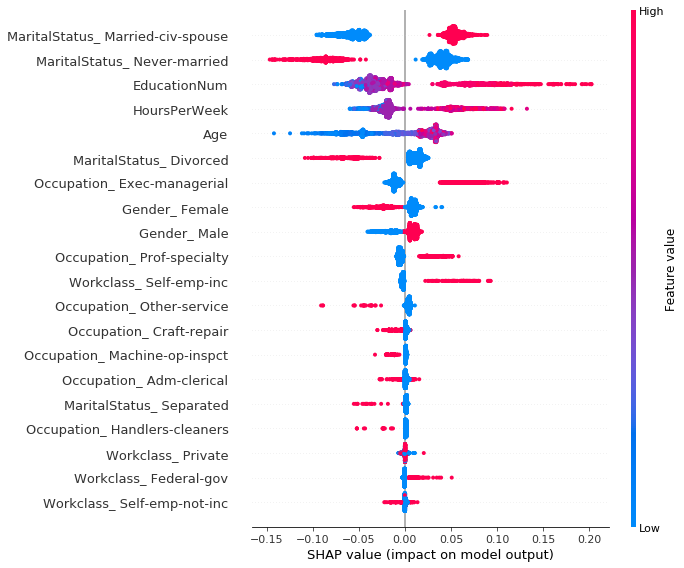

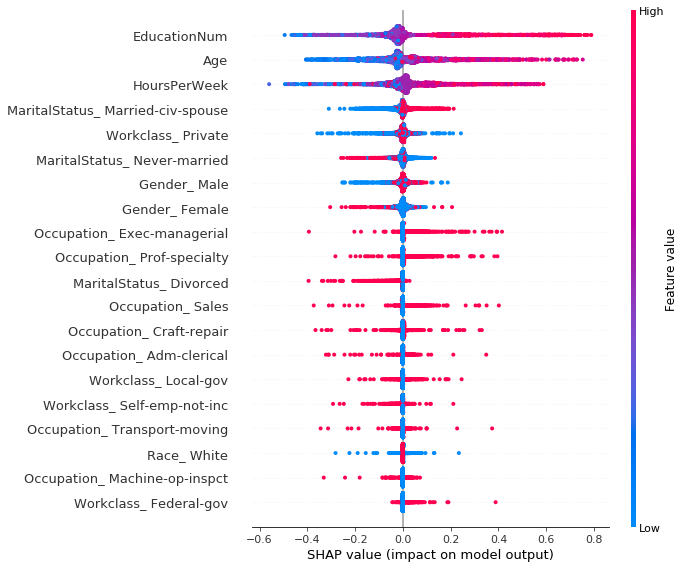

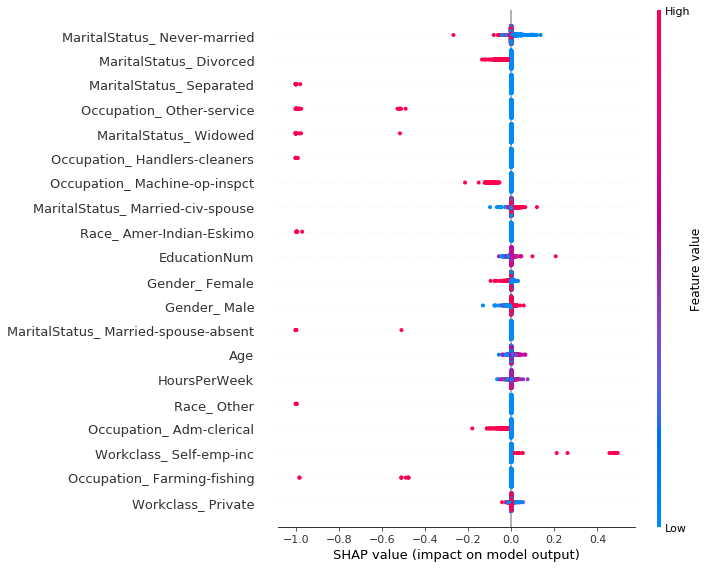

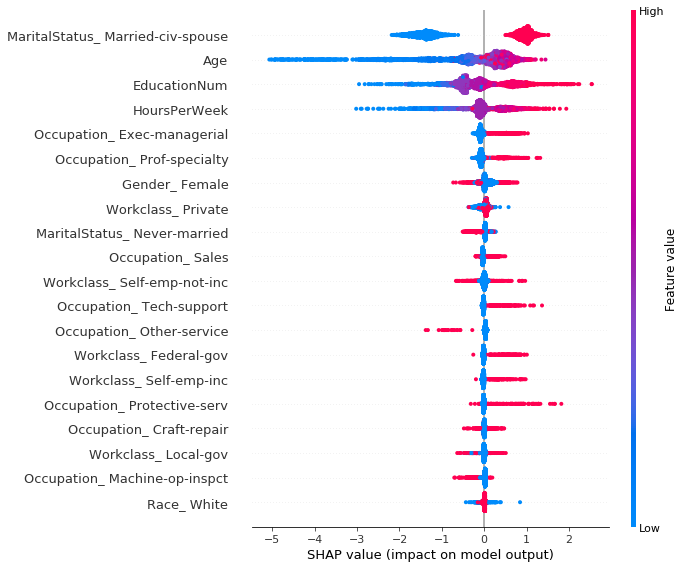

In [21]:
#Plot all the summary plots for SHAP for all models trained on segment 1
shap.summary_plot(rf_shap_values[1], X_test_segment1)
shap.summary_plot(knn_shap_values, X_test_segment1)
shap.summary_plot(gnb_shap_values, X_test_segment1)
shap.summary_plot(xgb_shap_values, X_test_segment1)

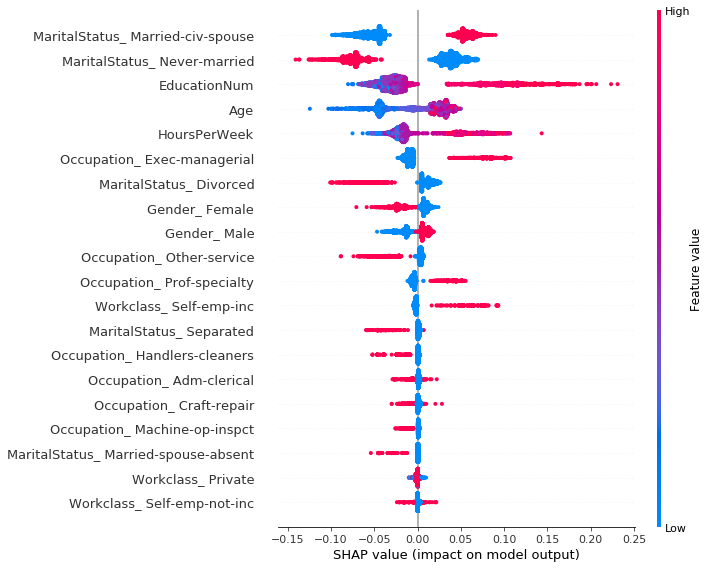

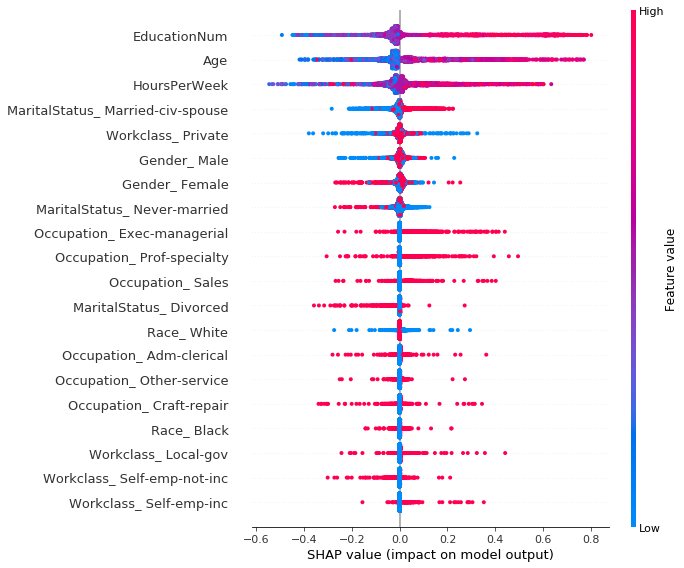

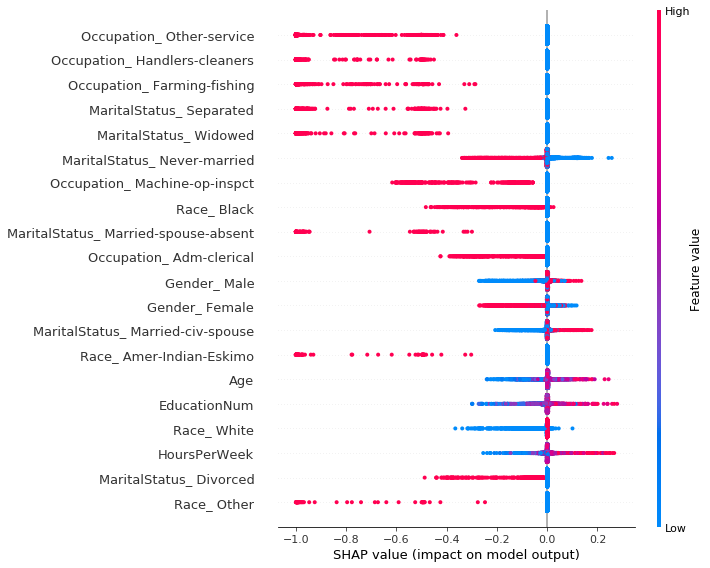

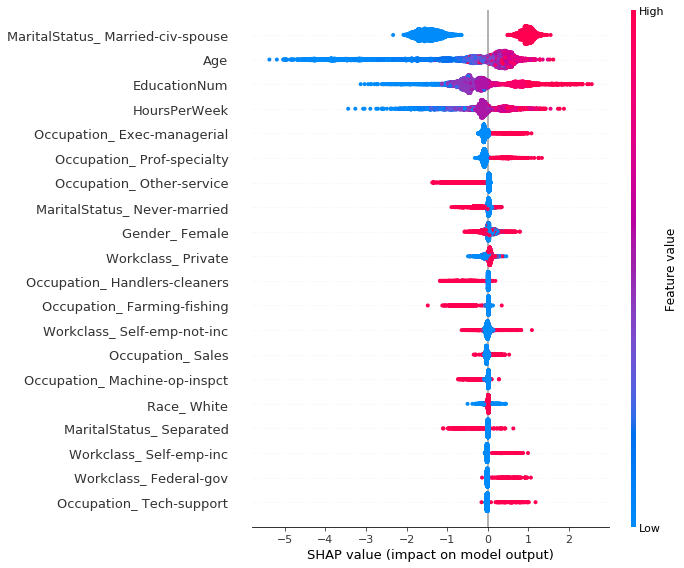

In [22]:
#Plot all the summary plots for SHAP for all models trained on segment 2
shap.summary_plot(rf_shap_values2[1], X_test_segment2)
shap.summary_plot(knn_shap_values2, X_test_segment2)
shap.summary_plot(gnb_shap_values2, X_test_segment2)
shap.summary_plot(xgb_shap_values2, X_test_segment2)